In [1]:
import sys

# Add the parent directory to the system path
sys.path.append("../04_survival_models/src")

In [2]:
import re
from collections import Counter

import mlflow
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon
from scipy.stats import norm
from azureml.core import Workspace
from uc2_functions import *
from tqdm import tqdm
import itertools
from io import BytesIO
from PIL import Image

In [3]:
np.random.seed(42)
sns.set(style="whitegrid")

# Goal

The goal is to compare survival models over Monte Carlo simulations.

# Parameters

In [4]:
DIR_GRANT_FINETUNE = "../02_survival_grant_finetune"
DIR_FEATURE_SELECTION = "../03_survival_feature_selection"
DIR_SURVIVAL_MODELS = "../04_survival_models"
DIR_ARTIFACTS = "artifacts"
DIR_FIGURES = "../figures"
PATH_METRICS_GRANT_FINETUNE_LARCHER = "df_metrics_UC2_larcher_survival_grant_finetune_2024_05.csv"
PATH_METRICS_GRANT_FINETUNE_RAW = "df_metrics_UC2_raw_survival_grant_finetune_2024_05.csv"
PATH_METRICS_FEATURE_SELECTION_LARCHER = "df_metrics_UC2_larcher_2024_02.csv"
PATH_METRICS_FEATURE_SELECTION_RAW = "df_metrics_UC2_raw_2024_02.csv"
PATH_METRICS_SURVIVAL_MODELS = "df_metrics_UC2_raw_survival_models_2024_07.csv"
# Number of simulations
S = 100

# Data ingestion

## GRANT finetune

### Larcher dataset

In [5]:
df_metrics_grant_finetune_larcher = pd.read_csv(os.path.join(DIR_GRANT_FINETUNE, DIR_ARTIFACTS, PATH_METRICS_GRANT_FINETUNE_LARCHER))
assert len(df_metrics_grant_finetune_larcher['random_state'].unique()) == S
print(df_metrics_grant_finetune_larcher.shape)
df_metrics_grant_finetune_larcher.head(2)

(100, 11)


,model,model_path,random_state,parent_run_id,n_features_in,feature_names_in,best_performance_tuning,concordance_index_censored,concordance_index_ipcw,integrated_brier_score,mean_cumulative_dynamic_auc
0,CoxPHSurvivalAnalysis_grant_finetune_T1,larcher_CoxPHSurvivalAnalysis_grant_finetune_T...,914,a8e78d0e-f32d-421d-badf-c13b5b22b65d,4,['age_binary' 'pT_binary' 'pN_1_0' 'grade_bina...,NaN,0.862387,0.860756,0.032927,0.856554
1,CoxPHSurvivalAnalysis_grant_finetune_T1,larcher_CoxPHSurvivalAnalysis_grant_finetune_T...,996,7f13d85f-7282-4bdd-82b1-1f789976f30a,4,['age_binary' 'pT_binary' 'pN_1_0' 'grade_bina...,NaN,0.795535,0.787342,0.035266,0.832178


### Raw dataset

In [6]:
df_metrics_grant_finetune_raw = pd.read_csv(os.path.join(DIR_GRANT_FINETUNE, DIR_ARTIFACTS, PATH_METRICS_GRANT_FINETUNE_RAW))
assert len(df_metrics_grant_finetune_raw['random_state'].unique()) == S
print(df_metrics_grant_finetune_raw.shape)
df_metrics_grant_finetune_raw.head(2)

(100, 11)


,model,model_path,random_state,parent_run_id,n_features_in,feature_names_in,best_performance_tuning,concordance_index_censored,concordance_index_ipcw,integrated_brier_score,mean_cumulative_dynamic_auc
0,CoxPHSurvivalAnalysis_grant_finetune_T1,raw_CoxPHSurvivalAnalysis_grant_finetune_T1_91...,914,7fe8ecc9-f795-43e3-81cc-06364e591407,4,['ANM_1_age_binary' 'IST_1_kidney1Pathological...,NaN,0.862387,0.860756,0.032973,0.856554
1,CoxPHSurvivalAnalysis_grant_finetune_T1,raw_CoxPHSurvivalAnalysis_grant_finetune_T1_99...,996,d0b45547-c4d5-4733-b7e3-8f9c325bcc4d,4,['ANM_1_age_binary' 'IST_1_kidney1Pathological...,NaN,0.780830,0.776292,0.035596,0.805372


## Feature selection models

### Larcher dataset

In [7]:
df_metrics_feature_selection_larcher = pd.read_csv(os.path.join(DIR_FEATURE_SELECTION, DIR_ARTIFACTS, PATH_METRICS_FEATURE_SELECTION_LARCHER))
assert len(df_metrics_feature_selection_larcher['random_state'].unique()) == S
df_metrics_feature_selection_larcher['model'] = df_metrics_feature_selection_larcher['model'].replace({"CoxPHSurvivalAnalysis_grant_finetune_T1": "CoxPHSurvivalAnalysis_grant_plus_T1"})
print(df_metrics_feature_selection_larcher.shape)
df_metrics_feature_selection_larcher.head(2)

(300, 11)


,model,model_path,random_state,parent_run_id,n_features_in,feature_names_in,best_performance_tuning,concordance_index_censored,concordance_index_ipcw,integrated_brier_score,mean_cumulative_dynamic_auc
0,RandomSurvivalForest_selector_T0,../models_json/larcher_RandomSurvivalForest_se...,914,cb8ea594-34b5-4386-9a23-ad0450103ba3,25,['age' 'sex_M' 'bmi' 'cci' 'asa' 'ecog' 'hyper...,-0.852294,0.840090,0.828644,0.036695,0.875013
1,RandomSurvivalForest_selector_T1,../models_json/larcher_RandomSurvivalForest_se...,914,cb8ea594-34b5-4386-9a23-ad0450103ba3,69,More than 50 features,-0.892419,0.881171,0.867921,0.033316,0.909046


### Raw dataset

In [8]:
df_metrics_feature_selection_raw = pd.read_csv(os.path.join(DIR_FEATURE_SELECTION, DIR_ARTIFACTS, PATH_METRICS_FEATURE_SELECTION_RAW))
assert len(df_metrics_feature_selection_raw['random_state'].unique()) == S
df_metrics_feature_selection_raw['model'] = df_metrics_feature_selection_raw['model'].replace({"CoxPHSurvivalAnalysis_grant_finetune_T1": "CoxPHSurvivalAnalysis_grant_plus_T1"})
print(df_metrics_feature_selection_raw.shape)
df_metrics_feature_selection_raw.head(2)

(300, 11)


,model,model_path,random_state,parent_run_id,n_features_in,feature_names_in,best_performance_tuning,concordance_index_censored,concordance_index_ipcw,integrated_brier_score,mean_cumulative_dynamic_auc
0,RandomSurvivalForest_selector_T0,../models_json/raw_RandomSurvivalForest_select...,914,136690ec-55ab-46b4-beef-22c6ef68009f,106,More than 50 features,-0.860191,0.834955,0.826034,0.036760,0.865922
1,RandomSurvivalForest_selector_T1,../models_json/raw_RandomSurvivalForest_select...,914,136690ec-55ab-46b4-beef-22c6ef68009f,206,More than 50 features,-0.901264,0.884324,0.871572,0.032311,0.914454


## Survival models

### Raw dataset

In [9]:
df_metrics_survival_models = pd.read_csv(os.path.join(DIR_SURVIVAL_MODELS, DIR_ARTIFACTS, PATH_METRICS_SURVIVAL_MODELS))
assert len(df_metrics_survival_models['random_state'].unique()) == S
print(df_metrics_survival_models.shape)
df_metrics_survival_models.head(2)

(1400, 11)


,model,model_path,random_state,parent_run_id,n_features_in,feature_names_in,best_performance_tuning,concordance_index_censored,concordance_index_ipcw,integrated_brier_score,mean_cumulative_dynamic_auc
0,SurvivalTree_T0,raw_SurvivalTree_T0_914.pkl,914,nice_neck_vjjn5n0fl2,10,NaN,-0.889352,0.747793,0.726216,0.039171,0.802505
1,CoxPHSurvivalAnalysis_T0,raw_CoxPHSurvivalAnalysis_T0_914.pkl,914,nice_neck_vjjn5n0fl2,13,NaN,-0.915822,0.796847,0.782320,0.039489,0.828209


# Compare random states

In [10]:
# Dictionary of DataFrames with their variable names as keys
dataframes = {
    'df_metrics_grant_finetune_raw': df_metrics_grant_finetune_raw,
    'df_metrics_feature_selection_raw': df_metrics_feature_selection_raw,
    'df_metrics_survival_models': df_metrics_survival_models,
    'df_metrics_grant_finetune_larcher': df_metrics_grant_finetune_larcher,
    'df_metrics_feature_selection_larcher': df_metrics_feature_selection_larcher,
}

# Generate all possible combinations of the dataframes
combinations = itertools.combinations(dataframes.items(), 2)

# Compare each combination
for (name1, df1), (name2, df2) in combinations:
    compare_random_states(df1, df2, name1, name2)

# Concat

In [11]:
time_groups_larcher = {"T0 selector": ['RandomSurvivalForest_selector_T0'],
        "T1 benchmark": ['CoxPHSurvivalAnalysis_grant_finetune_T1', 'CoxPHSurvivalAnalysis_grant_plus_T1'],
        "T1 selector": ['RandomSurvivalForest_selector_T1']}

color_groups_larcher = {"T0 selector": "#ec7d10",
        "T1 benchmark": "#7f7f7f",
        "T1 selector": "#64a6bd"}


time_groups_raw = {"T0 selector": ['RandomSurvivalForest_selector_T0'],
                      "T0 models": ['SurvivalTree_T0',
                      'CoxPHSurvivalAnalysis_T0',
                      'CoxnetSurvivalAnalysis_T0',
                      'RandomSurvivalForest_T0',
                      'ExtraSurvivalTrees_T0', 
                      'GradientBoostingSurvivalAnalysis_T0',
                      'ComponentwiseGradientBoostingSurvivalAnalysis_T0'],
        "T1 benchmark": ['CoxPHSurvivalAnalysis_grant_finetune_T1', 'CoxPHSurvivalAnalysis_grant_plus_T1'],
        "T1 selector": ['RandomSurvivalForest_selector_T1'],
        "T1 models": ['SurvivalTree_T1',
               'CoxPHSurvivalAnalysis_T1',
               'CoxnetSurvivalAnalysis_T1',
               'RandomSurvivalForest_T1',
               'ExtraSurvivalTrees_T1',
               'GradientBoostingSurvivalAnalysis_T1',
               'ComponentwiseGradientBoostingSurvivalAnalysis_T1']}

color_groups_raw = {"T0 selector": "#ec7d10",
                "T0 models": "#fc2f00",
        "T1 benchmark": "#7f7f7f",
        "T1 selector": "#64a6bd",
        "T1 models": "#2b59c3"}

In [12]:
# List of T1 models to be removed for T0 analysis
t1_models = time_groups_raw['T1 selector'] + time_groups_raw['T1 models'] + ['CoxPHSurvivalAnalysis_grant_plus_T1']


# All metrics for larcher dataset
df_metrics_larcher = pd.concat([df_metrics_grant_finetune_larcher, df_metrics_feature_selection_larcher])
df_metrics_larcher['dataset'] = "Clinician’s dataset"
# Only T0 DBURI models + T1 GRANT
df_metrics_larcher_t0 = df_metrics_larcher[~df_metrics_larcher['model'].isin(t1_models)]
# All metrics for raw dataset
df_metrics = pd.concat([df_metrics_grant_finetune_raw, df_metrics_feature_selection_raw, df_metrics_survival_models])
df_metrics['dataset'] = "Raw DBURI dataset"
# Only T0 DBURI models + T1 GRANT
df_metrics_t0 = df_metrics[~df_metrics['model'].isin(t1_models)]
# Dataset to compare larcher and raw
df_metrics_vs = pd.concat([df_metrics_larcher, df_metrics])
df_metrics_vs_t0 = pd.concat([df_metrics_larcher_t0, df_metrics_t0])
common_models = df_metrics_vs[df_metrics_vs['dataset'] == "Clinician’s dataset"]['model'].unique().tolist()
df_metrics_vs = df_metrics_vs[df_metrics_vs['model'].isin(common_models)]
df_metrics_vs_t0 = df_metrics_vs_t0[df_metrics_vs_t0['model'].isin(common_models)]

# EDA on metrics

(currently only T0 visualizations, to expand to T1 models, remove the suffix _t0 from the variable name

In [13]:
dict_fig = dict()

## Larcher vs raw dataset at T1 + T0

<Axes: title={'center': 'concordance_index_censored'}, ylabel='Value over MCCV Simulations'>

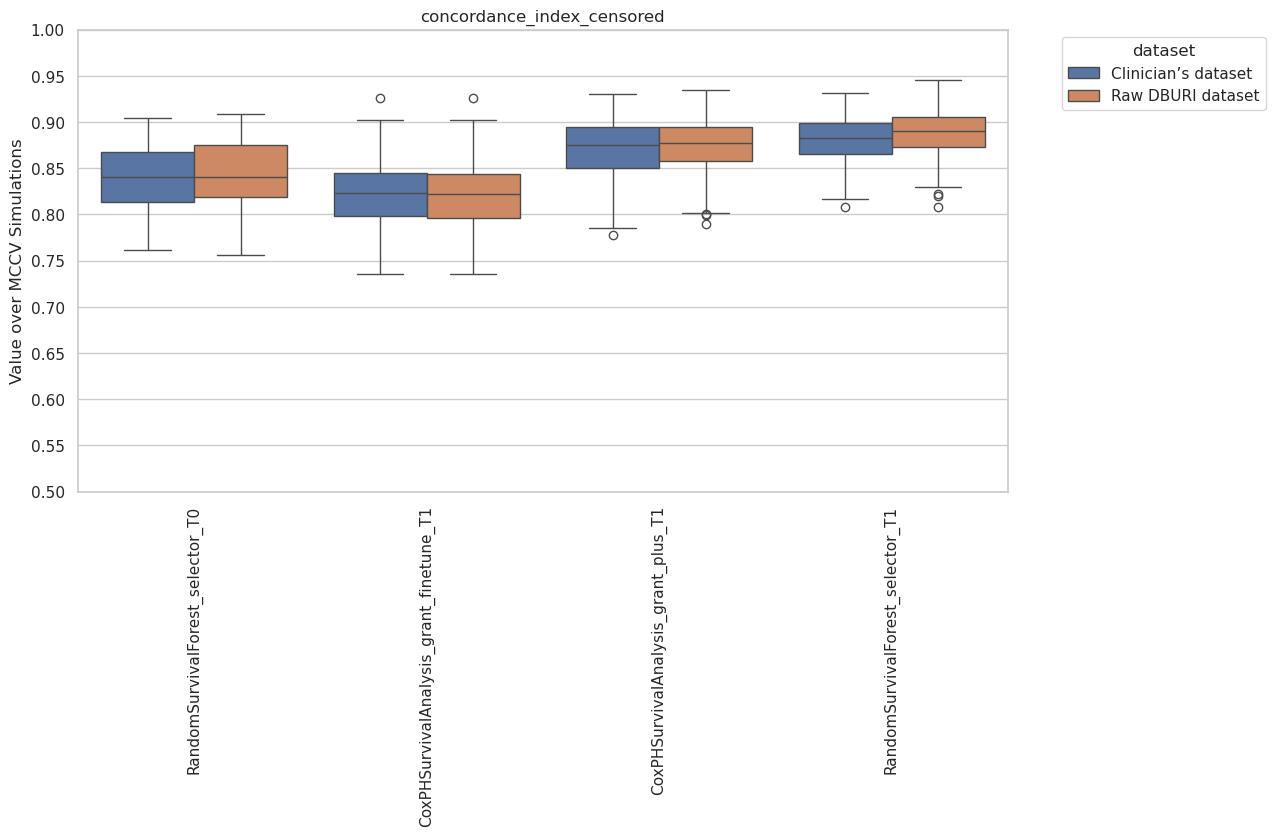

In [14]:
plot_metric_boxplot(df_metrics_vs, 'concordance_index_censored', time_groups_larcher, color_groups_larcher, hue_column="dataset")

<Axes: title={'center': 'concordance_index_ipcw'}, ylabel='Value over MCCV Simulations'>

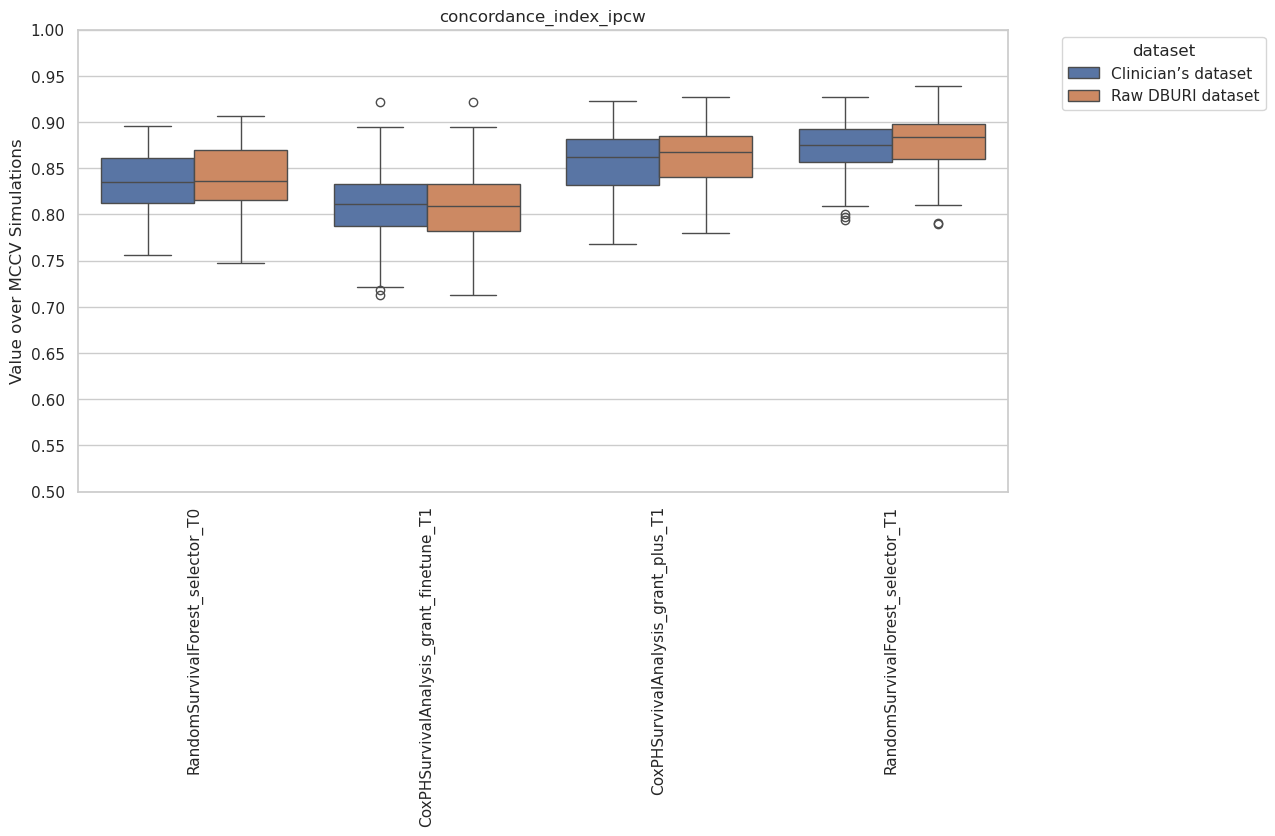

In [15]:
plot_metric_boxplot(df_metrics_vs, 'concordance_index_ipcw', time_groups_larcher, color_groups_larcher, hue_column="dataset")

<Axes: title={'center': 'integrated_brier_score'}, ylabel='Value over MCCV Simulations'>

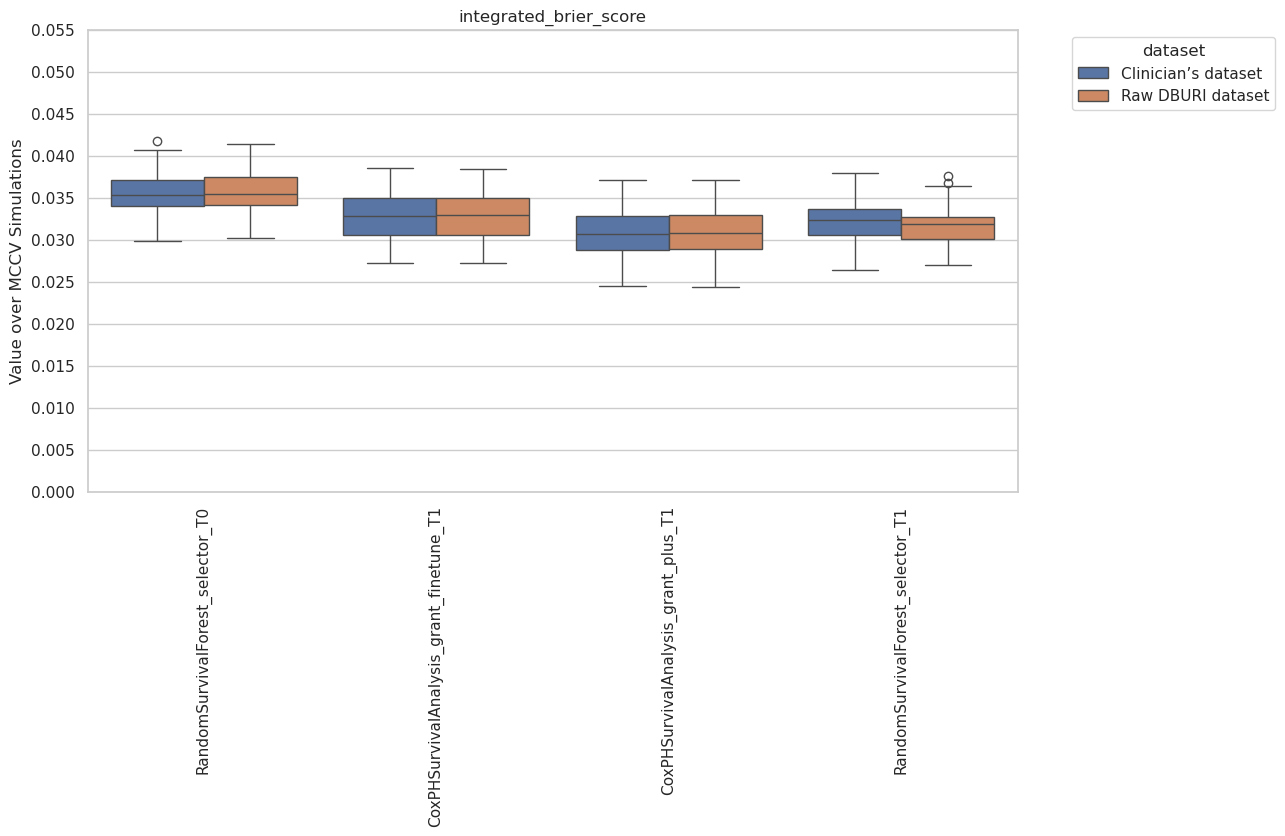

In [16]:
plot_metric_boxplot(df_metrics_vs, 'integrated_brier_score', time_groups_larcher, color_groups_larcher, hue_column="dataset")

<Axes: title={'center': 'mean_cumulative_dynamic_auc'}, ylabel='Value over MCCV Simulations'>

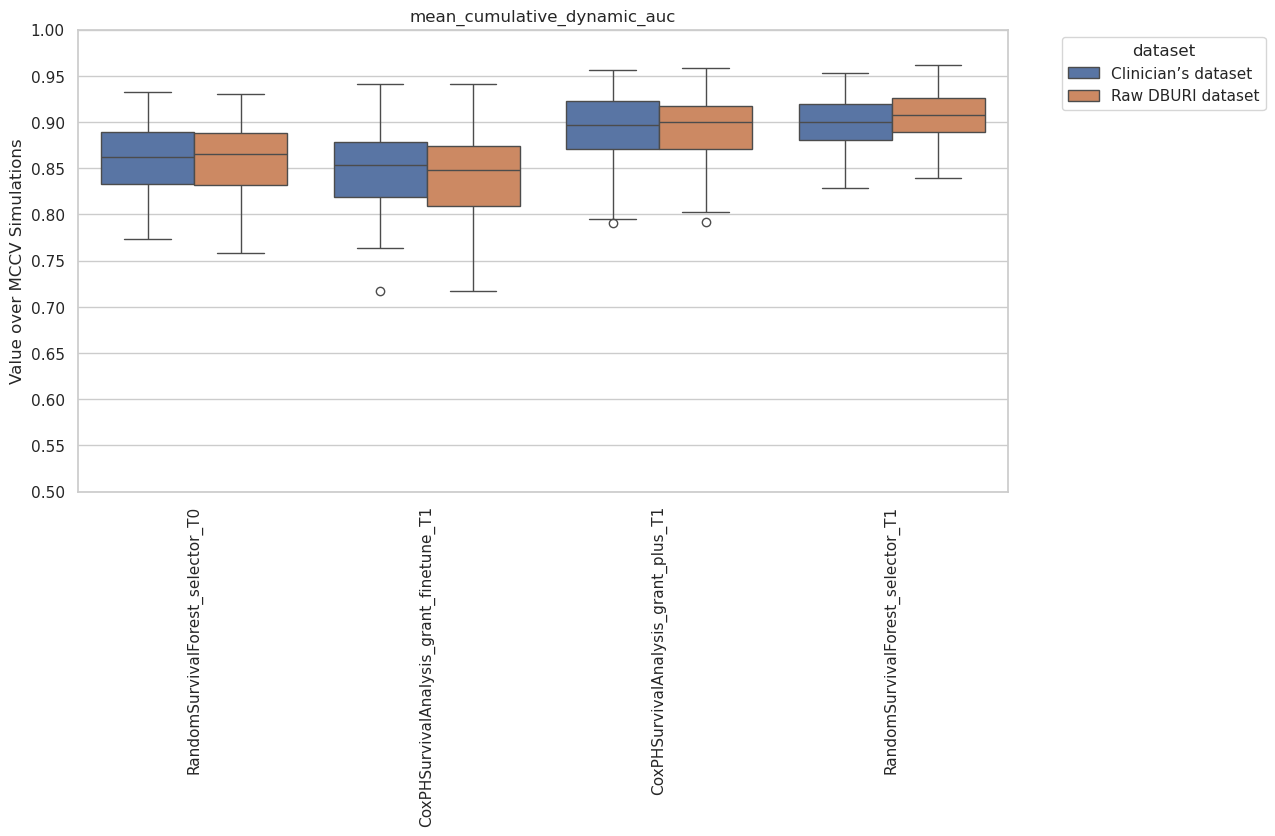

In [17]:
plot_metric_boxplot(df_metrics_vs, 'mean_cumulative_dynamic_auc', time_groups_larcher, color_groups_larcher, hue_column="dataset")

## Larcher vs raw dataset at T0

<Axes: title={'center': 'concordance_index_censored'}, ylabel='Value over MCCV Simulations'>

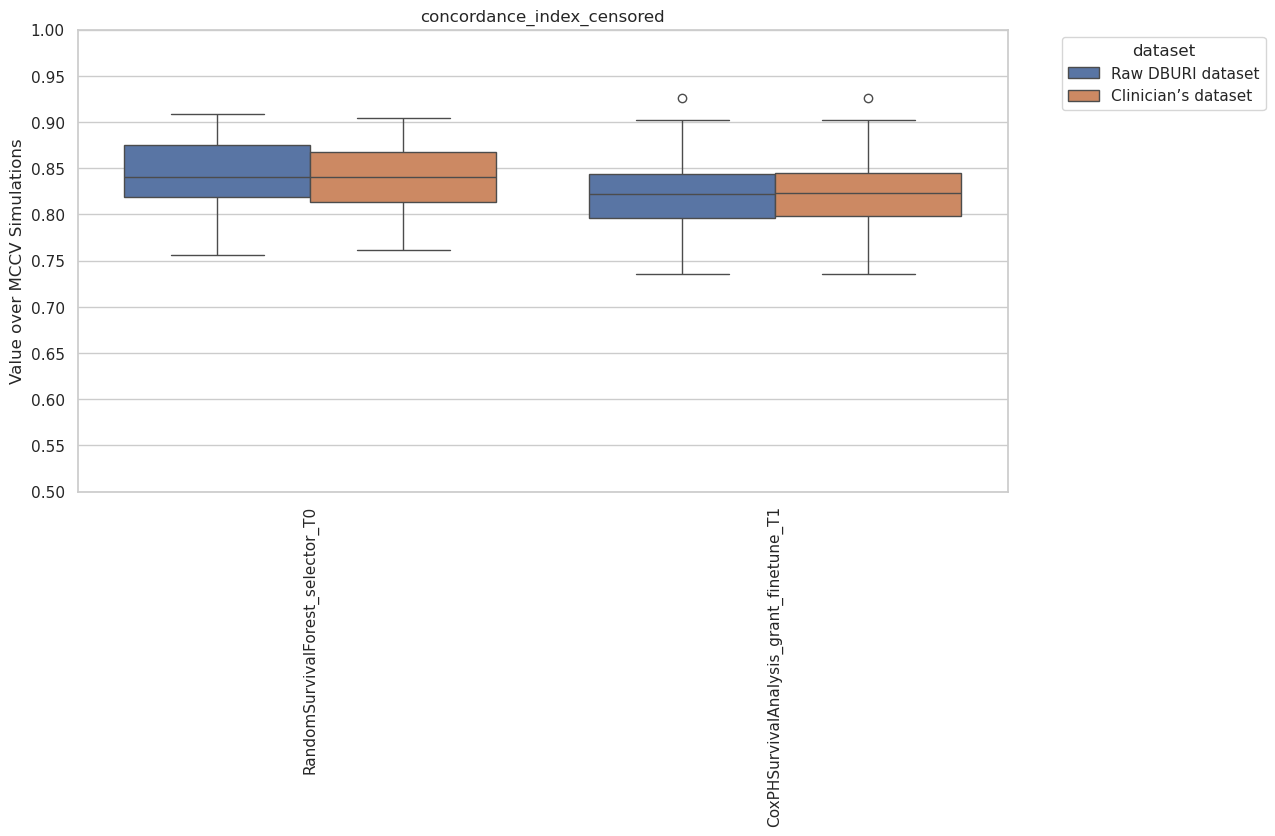

In [18]:
plot_metric_boxplot(df_metrics_vs_t0, 'concordance_index_censored', time_groups_larcher, color_groups_larcher, hue_column="dataset")

<Axes: title={'center': 'concordance_index_ipcw'}, ylabel='Value over MCCV Simulations'>

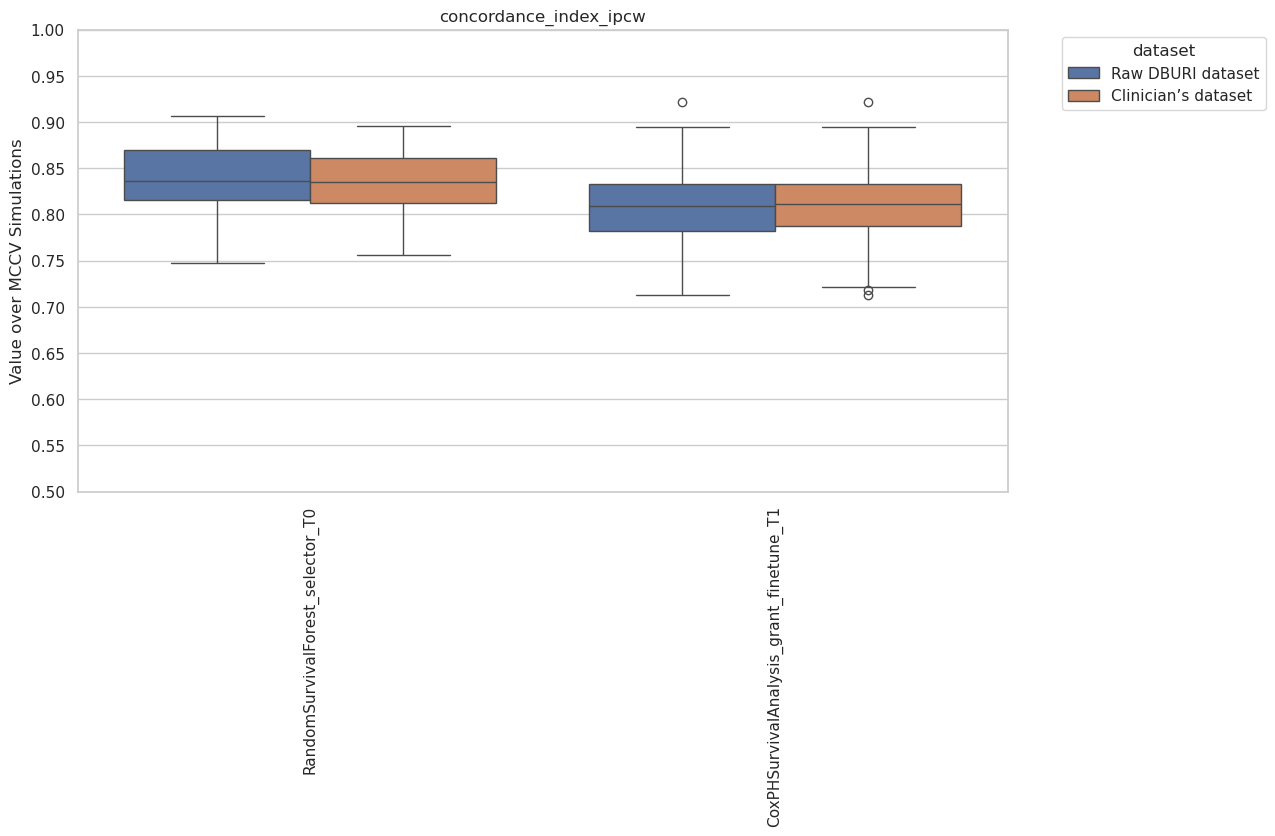

In [19]:
plot_metric_boxplot(df_metrics_vs_t0, 'concordance_index_ipcw', time_groups_larcher, color_groups_larcher, hue_column="dataset")

<Axes: title={'center': 'integrated_brier_score'}, ylabel='Value over MCCV Simulations'>

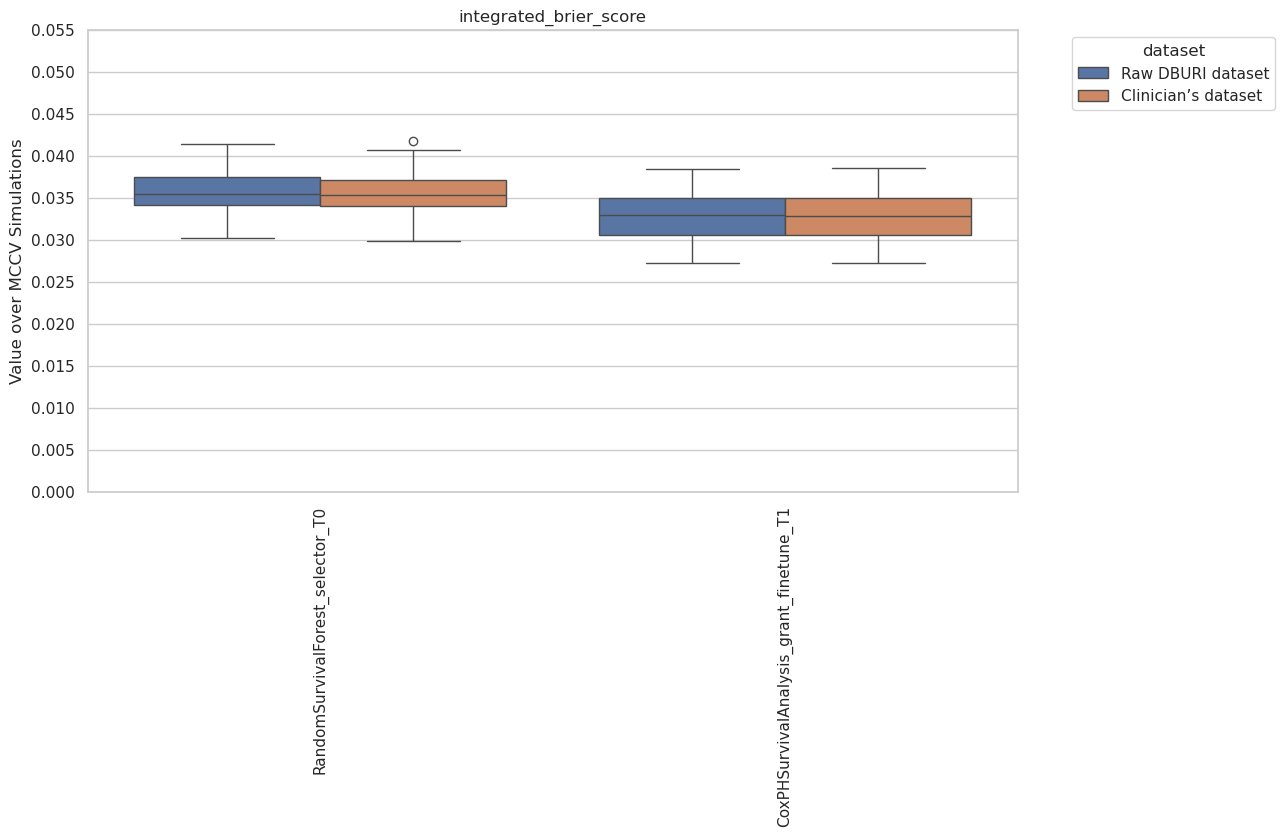

In [20]:
plot_metric_boxplot(df_metrics_vs_t0, 'integrated_brier_score', time_groups_larcher, color_groups_larcher, hue_column="dataset")

<Axes: title={'center': 'mean_cumulative_dynamic_auc'}, ylabel='Value over MCCV Simulations'>

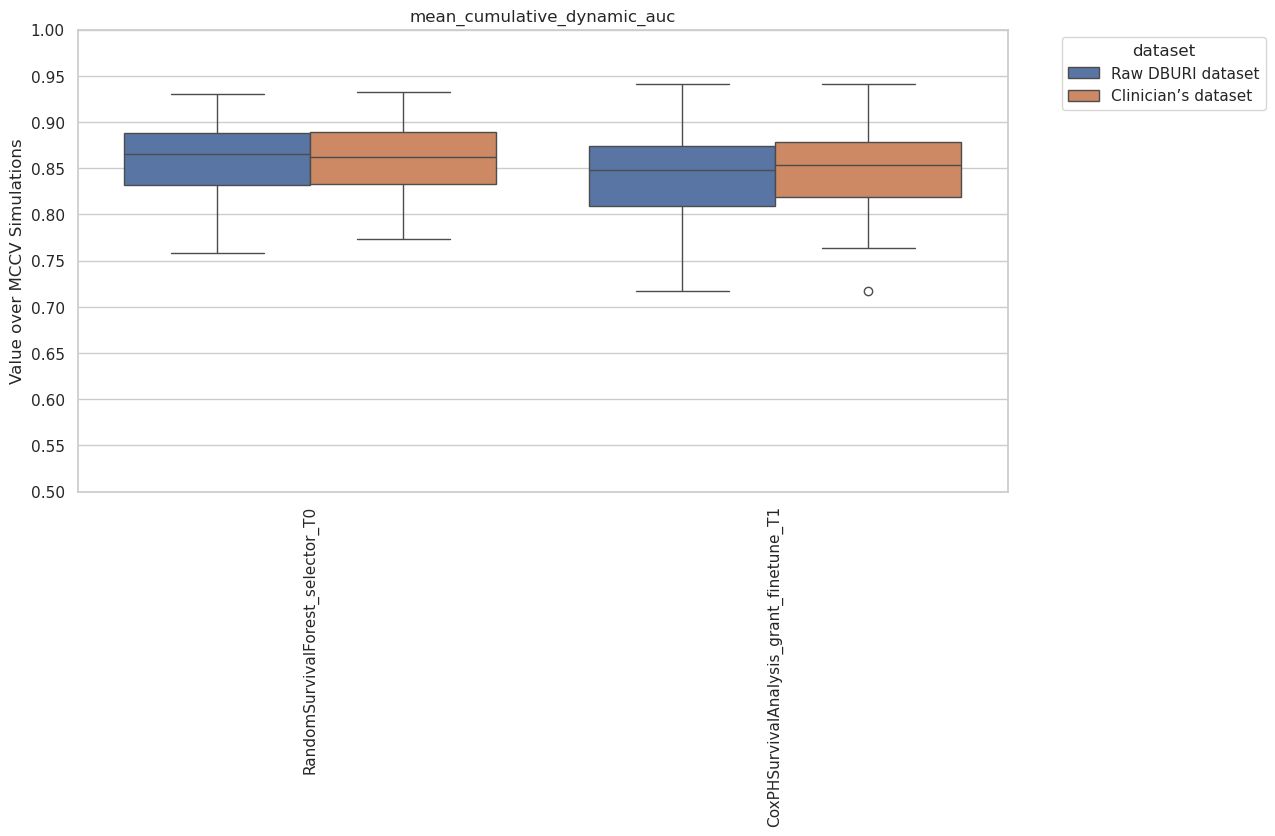

In [21]:
plot_metric_boxplot(df_metrics_vs_t0, 'mean_cumulative_dynamic_auc', time_groups_larcher, color_groups_larcher, hue_column="dataset")

### Multiple plots in 1 figure

3it [00:00, 14.43it/s]


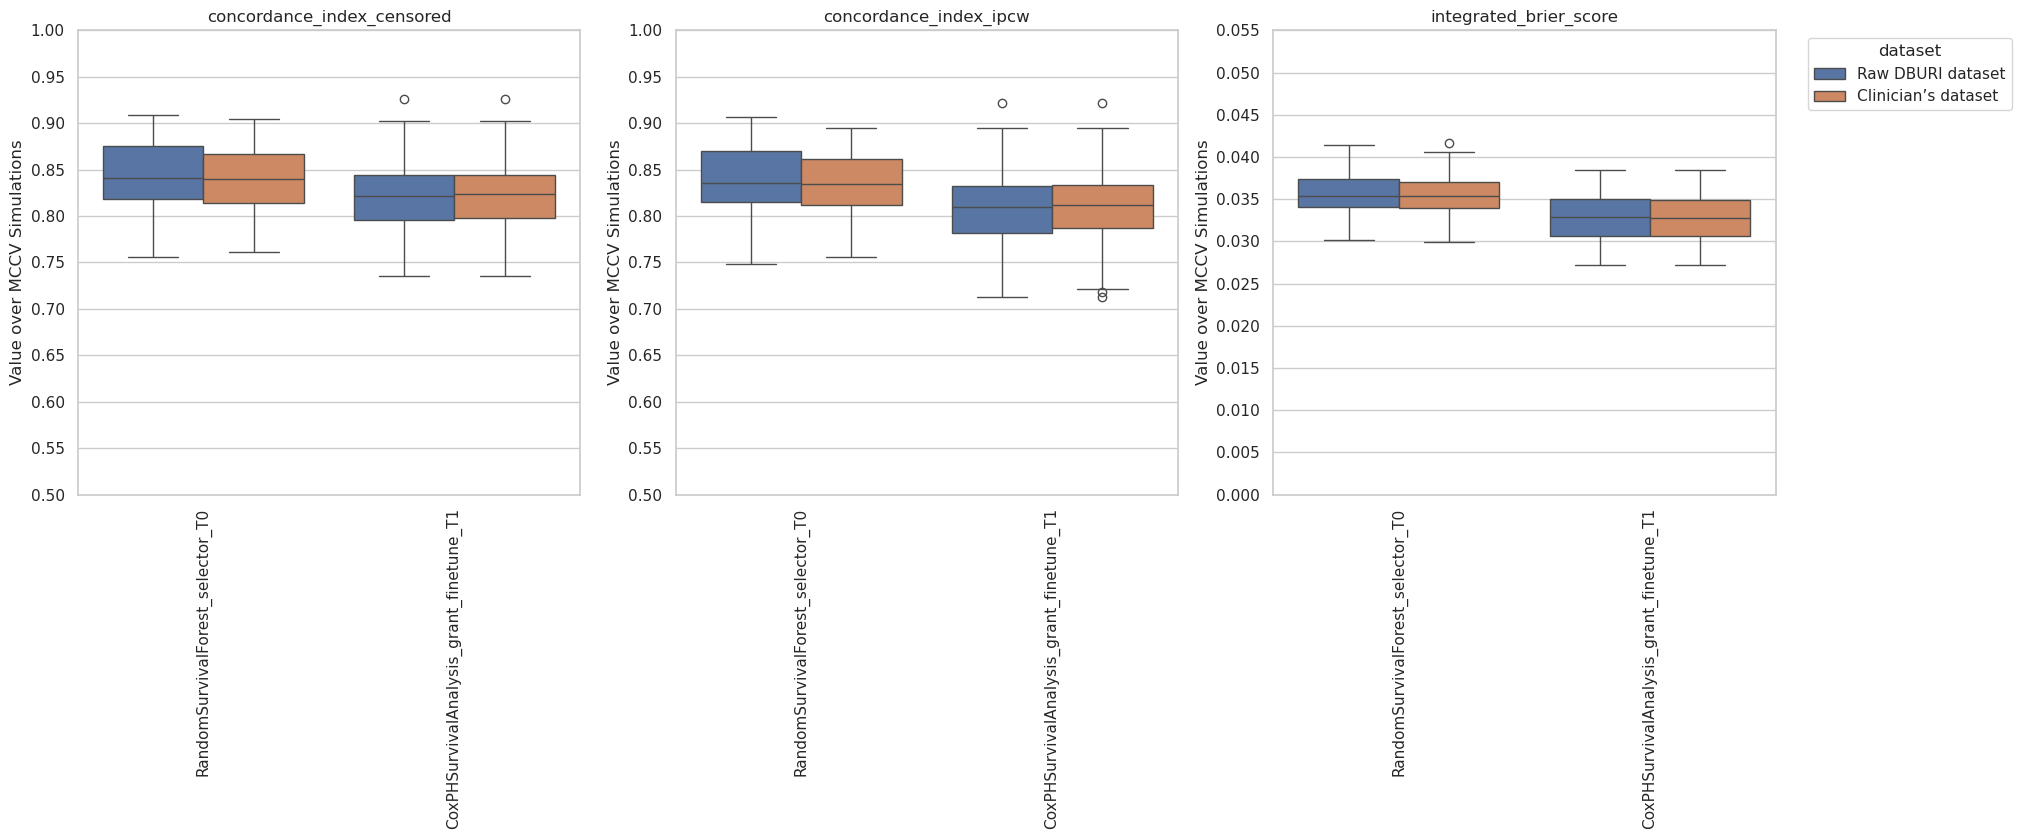

In [22]:
metrics = [
    'concordance_index_censored',
    'concordance_index_ipcw',
    'integrated_brier_score',
]
hue_column = "dataset"


# Determine the number of metrics to set up subplots
num_metrics = len(metrics)
cols = 3  # Number of columns in the subplot grid
rows = (num_metrics + cols - 1) // cols  # Calculate the number of rows needed
# Create the composite figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 9), squeeze=False)
axes_flat = axes.flatten()

dict_fig = {}
for idx, metric in tqdm(enumerate(metrics)):
    ax = axes_flat[idx]
    plot_metric_boxplot(
        df_metrics=df_metrics_vs_t0,
        metric=metric,
        time_groups=time_groups_larcher,
        color_groups=color_groups_larcher,
        hue_column=hue_column,
        ax=ax
    )
    if idx == len(metrics) - 1:
        # Add legend to the last ax
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title=hue_column, loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)
    else:
        # Remove legend
        ax.get_legend().remove()
    dict_fig[metric] = ax

# Hide any unused subplots
for idx in range(len(metrics), len(axes_flat)):
    fig.delaxes(axes_flat[idx])
# Adjust layout to accommodate the suptitle and the single legend
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

# **Saving with Pillow to Control JPEG Quality**
# Create a buffer to save the figure as PNG
buf = BytesIO()
fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
buf.seek(0)
# Open the image with Pillow and save as JPEG with desired quality
img = Image.open(buf)
os.makedirs(DIR_FIGURES, exist_ok=True)
img.convert("RGB").save(os.path.join(DIR_FIGURES, "raw_vs_larcher_mccv_internal_val.jpg"), format='JPEG', quality=95)
plt.show()

## All models on raw dataset at T1 + T0

<Axes: title={'center': 'concordance_index_censored'}, ylabel='Value over MCCV Simulations'>

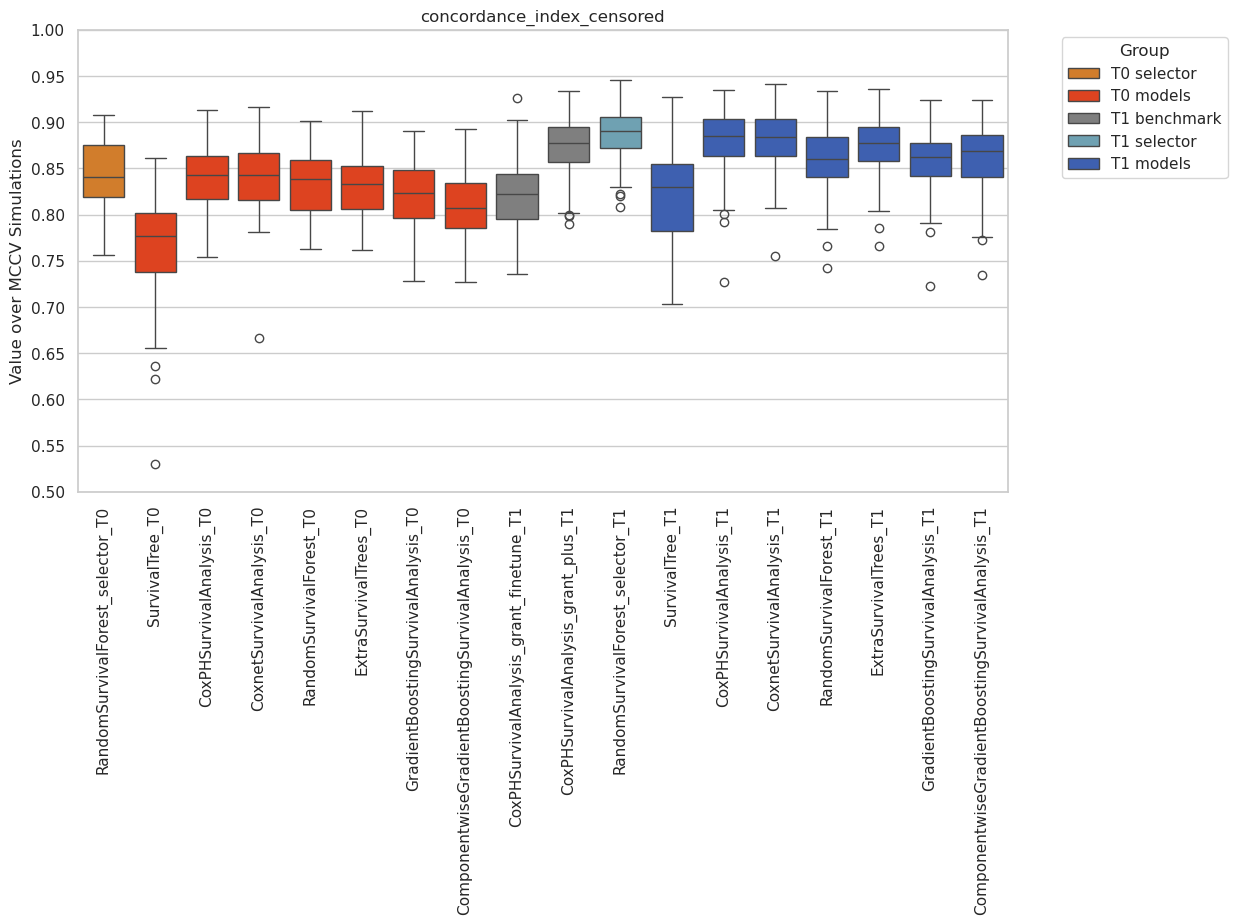

In [23]:
plot_metric_boxplot(df_metrics, 'concordance_index_censored', time_groups_raw, color_groups_raw)

<Axes: title={'center': 'concordance_index_ipcw'}, ylabel='Value over MCCV Simulations'>

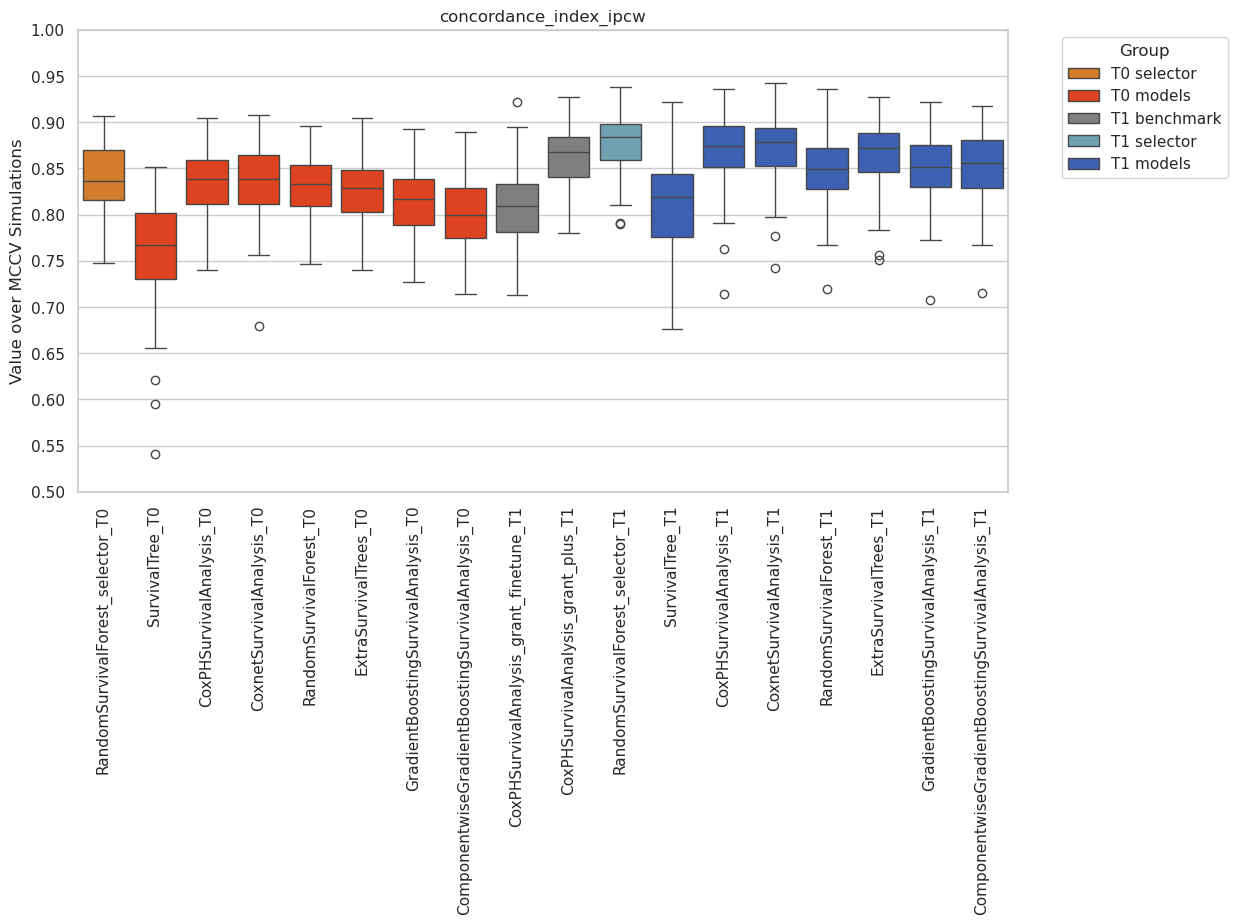

In [24]:
plot_metric_boxplot(df_metrics, 'concordance_index_ipcw', time_groups_raw, color_groups_raw)

<Axes: title={'center': 'integrated_brier_score'}, ylabel='Value over MCCV Simulations'>

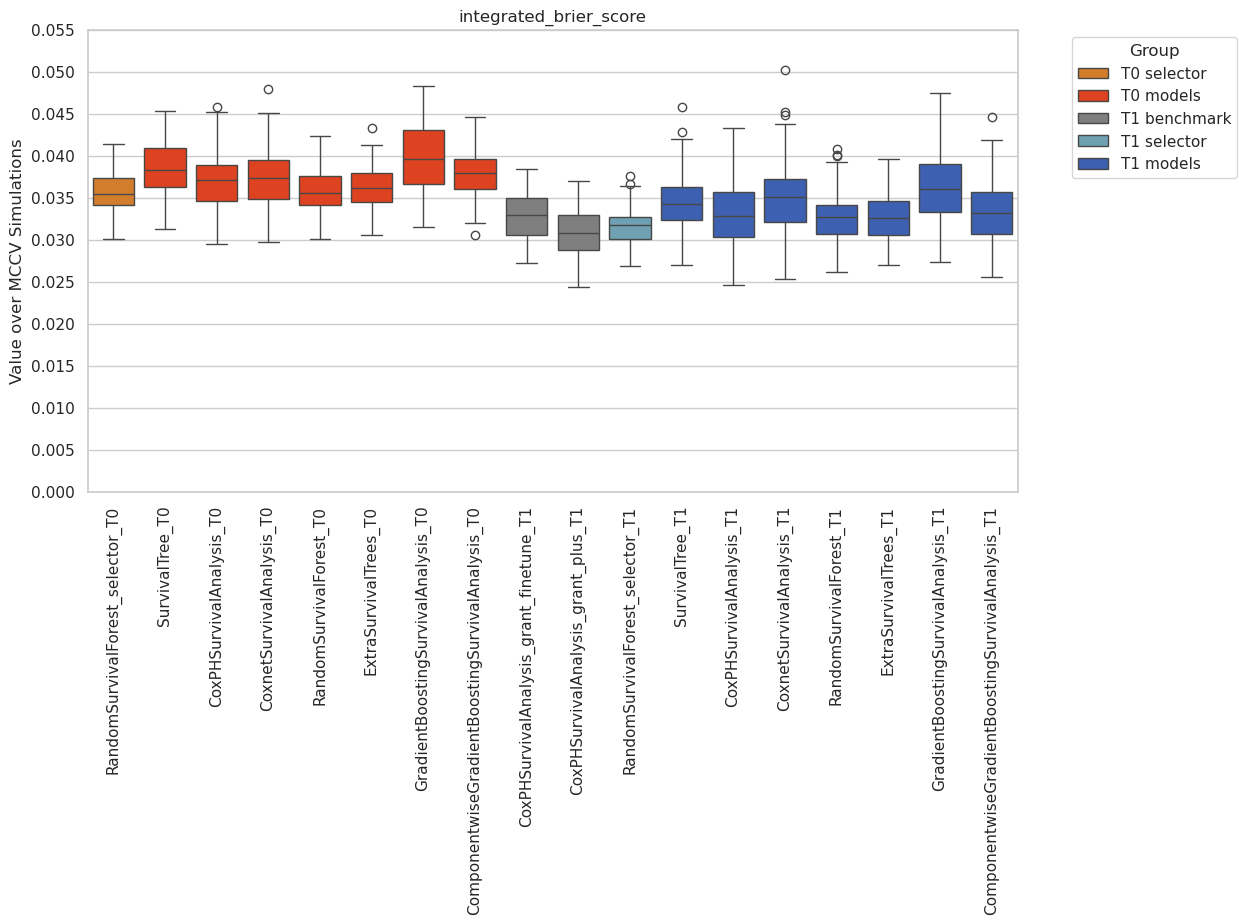

In [25]:
plot_metric_boxplot(df_metrics, 'integrated_brier_score', time_groups_raw, color_groups_raw)

<Axes: title={'center': 'mean_cumulative_dynamic_auc'}, ylabel='Value over MCCV Simulations'>

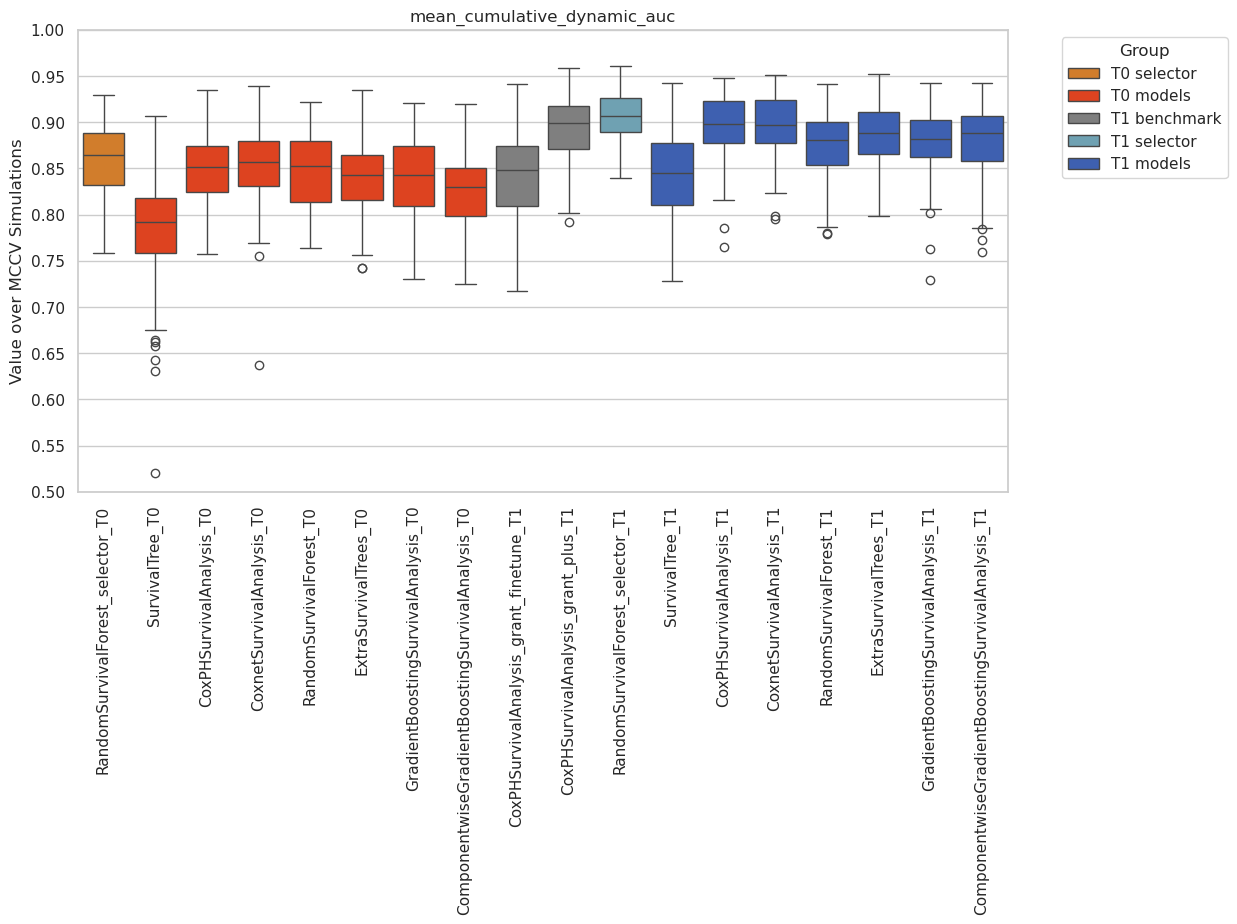

In [26]:
plot_metric_boxplot(df_metrics, 'mean_cumulative_dynamic_auc', time_groups_raw, color_groups_raw)

## All models on raw dataset at T0

<Axes: title={'center': 'concordance_index_censored'}, ylabel='Value over MCCV Simulations'>

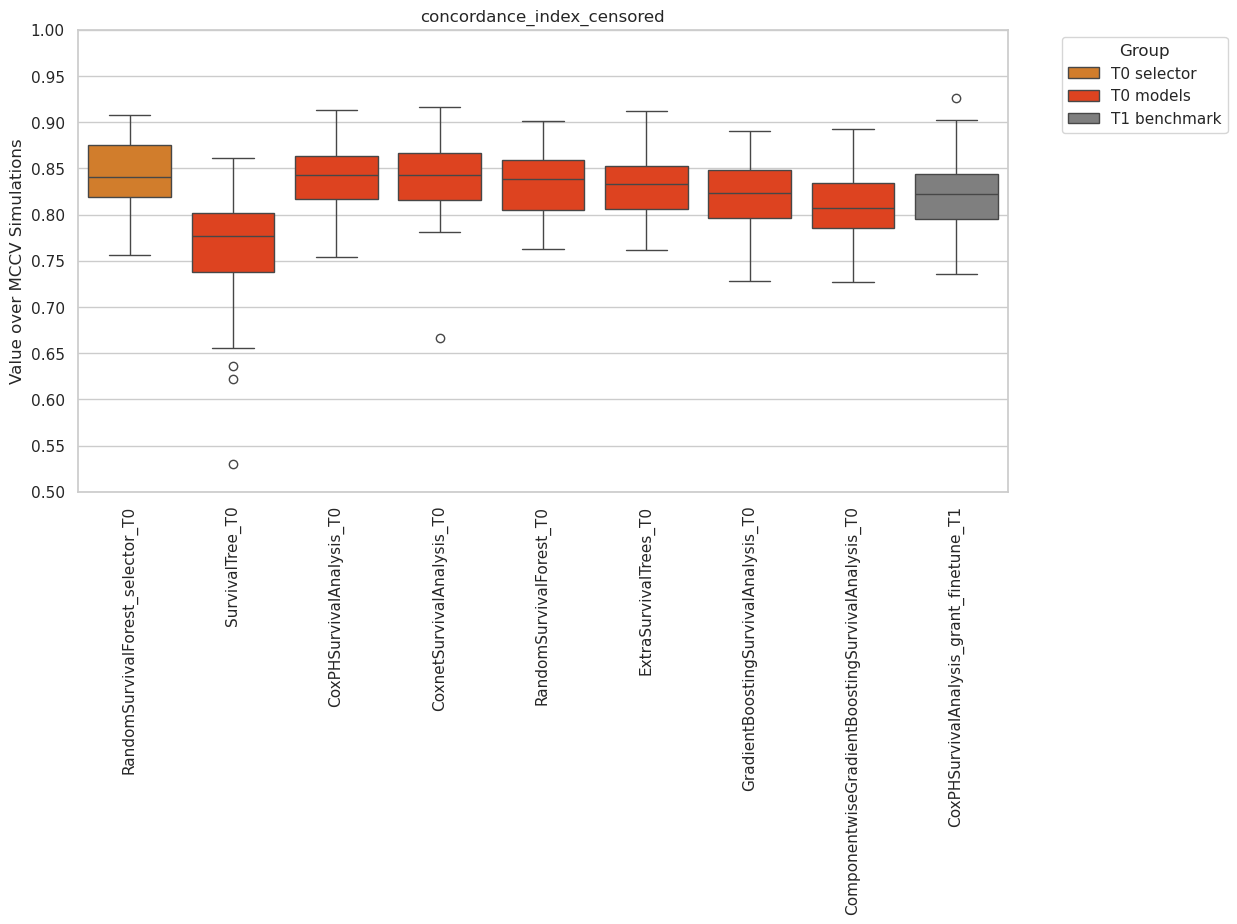

In [27]:
plot_metric_boxplot(df_metrics_t0, 'concordance_index_censored', time_groups_raw, color_groups_raw)

<Axes: title={'center': 'concordance_index_ipcw'}, ylabel='Value over MCCV Simulations'>

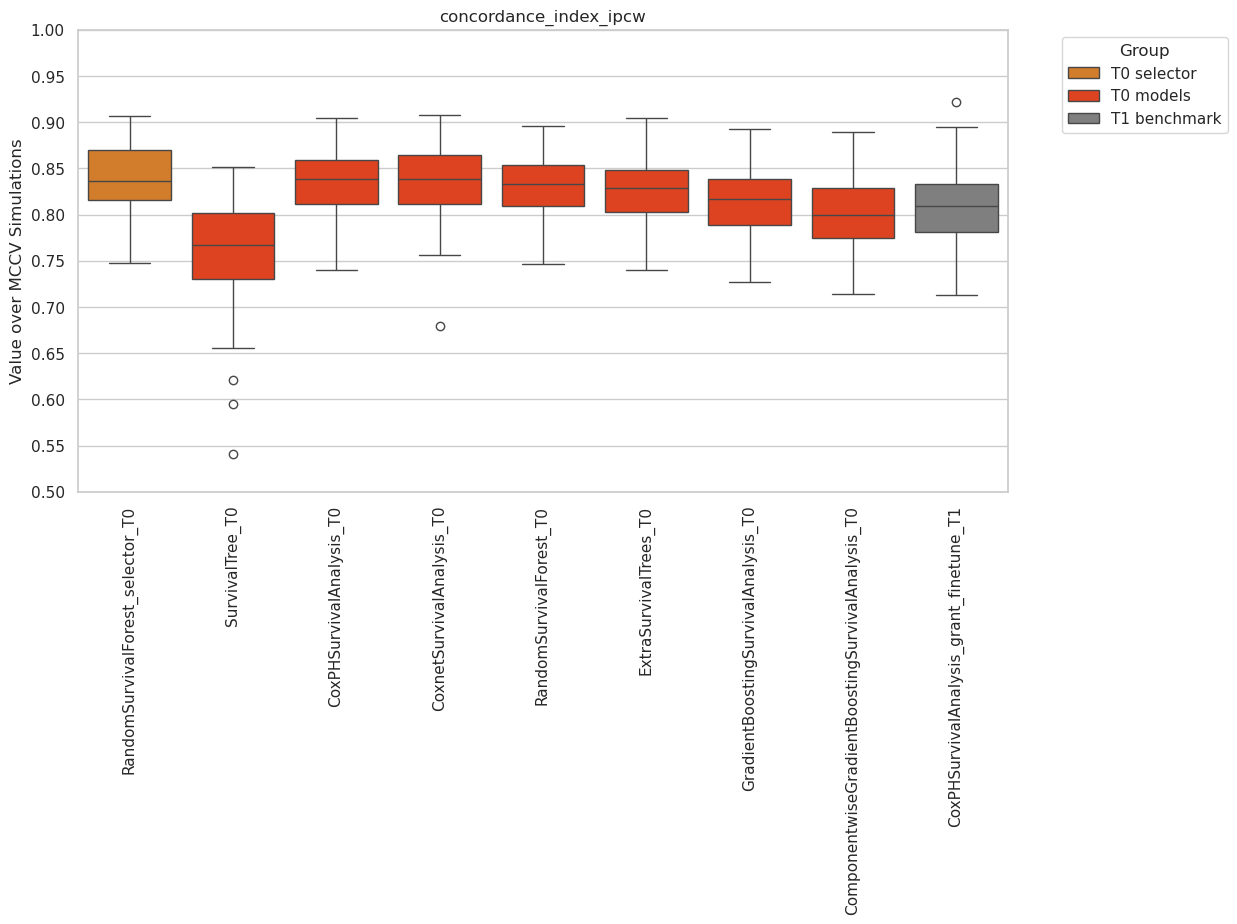

In [28]:
plot_metric_boxplot(df_metrics_t0, 'concordance_index_ipcw', time_groups_raw, color_groups_raw)

<Axes: title={'center': 'integrated_brier_score'}, ylabel='Value over MCCV Simulations'>

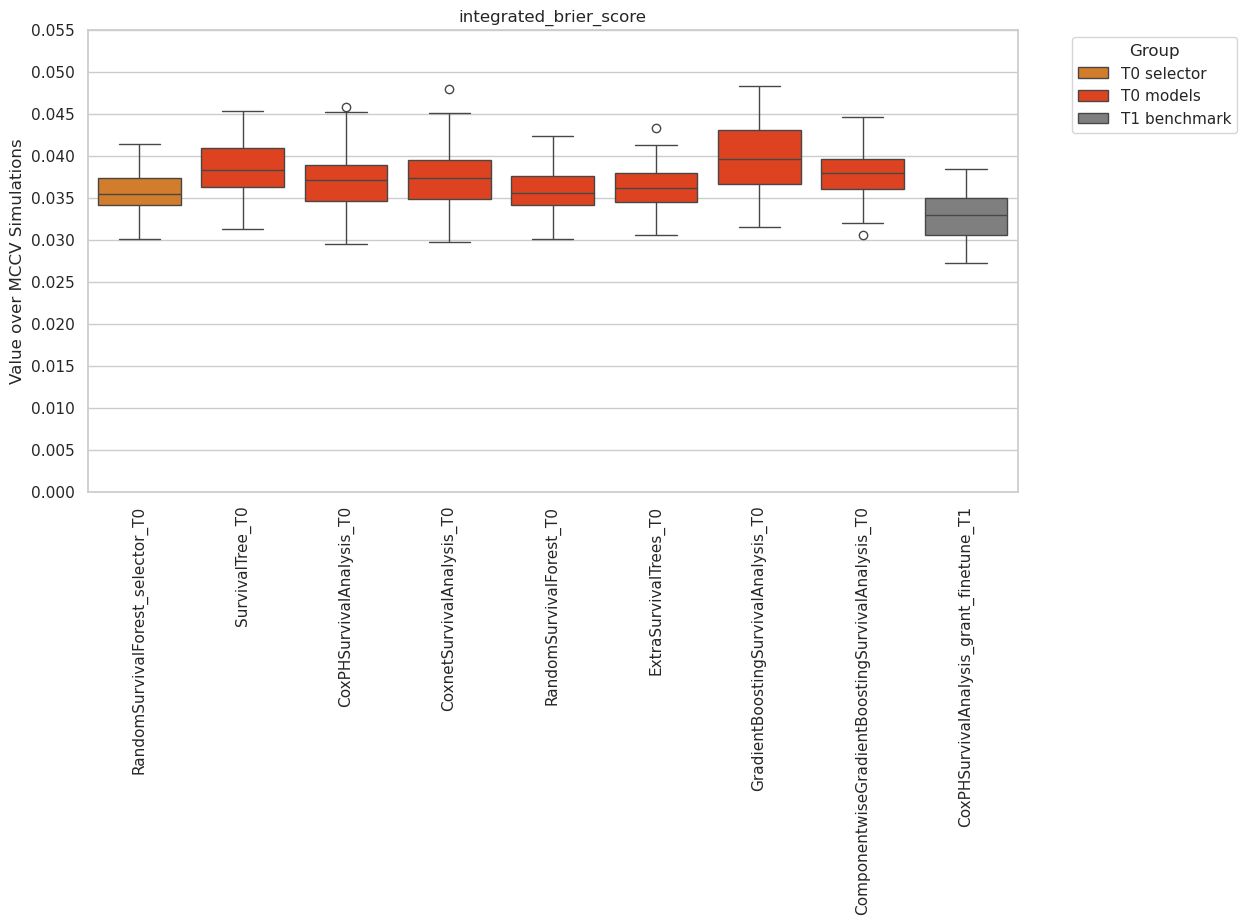

In [29]:
plot_metric_boxplot(df_metrics_t0, 'integrated_brier_score', time_groups_raw, color_groups_raw)

<Axes: title={'center': 'mean_cumulative_dynamic_auc'}, ylabel='Value over MCCV Simulations'>

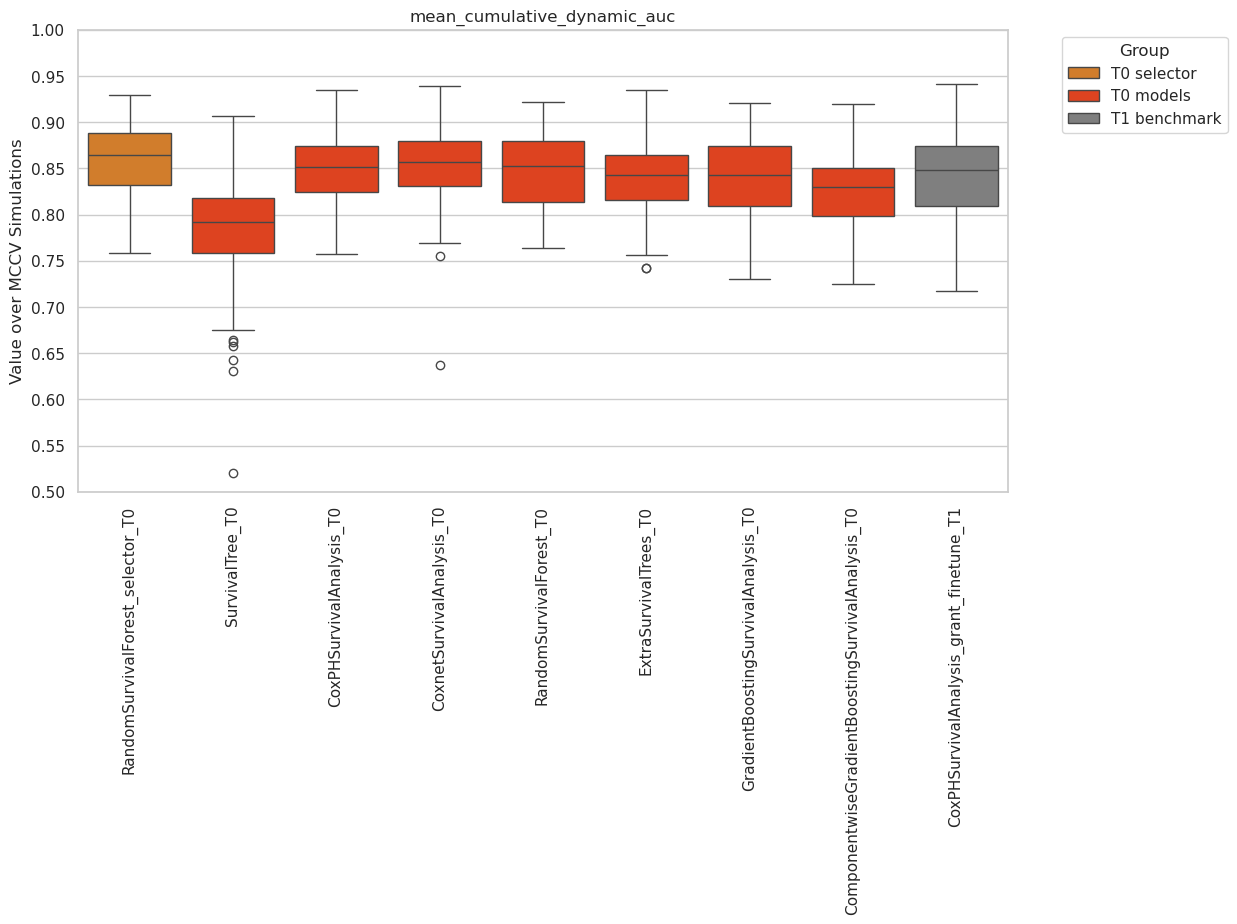

In [30]:
plot_metric_boxplot(df_metrics_t0, 'mean_cumulative_dynamic_auc', time_groups_raw, color_groups_raw)

### Multiple plots in 1 figure

3it [00:00,  9.40it/s]


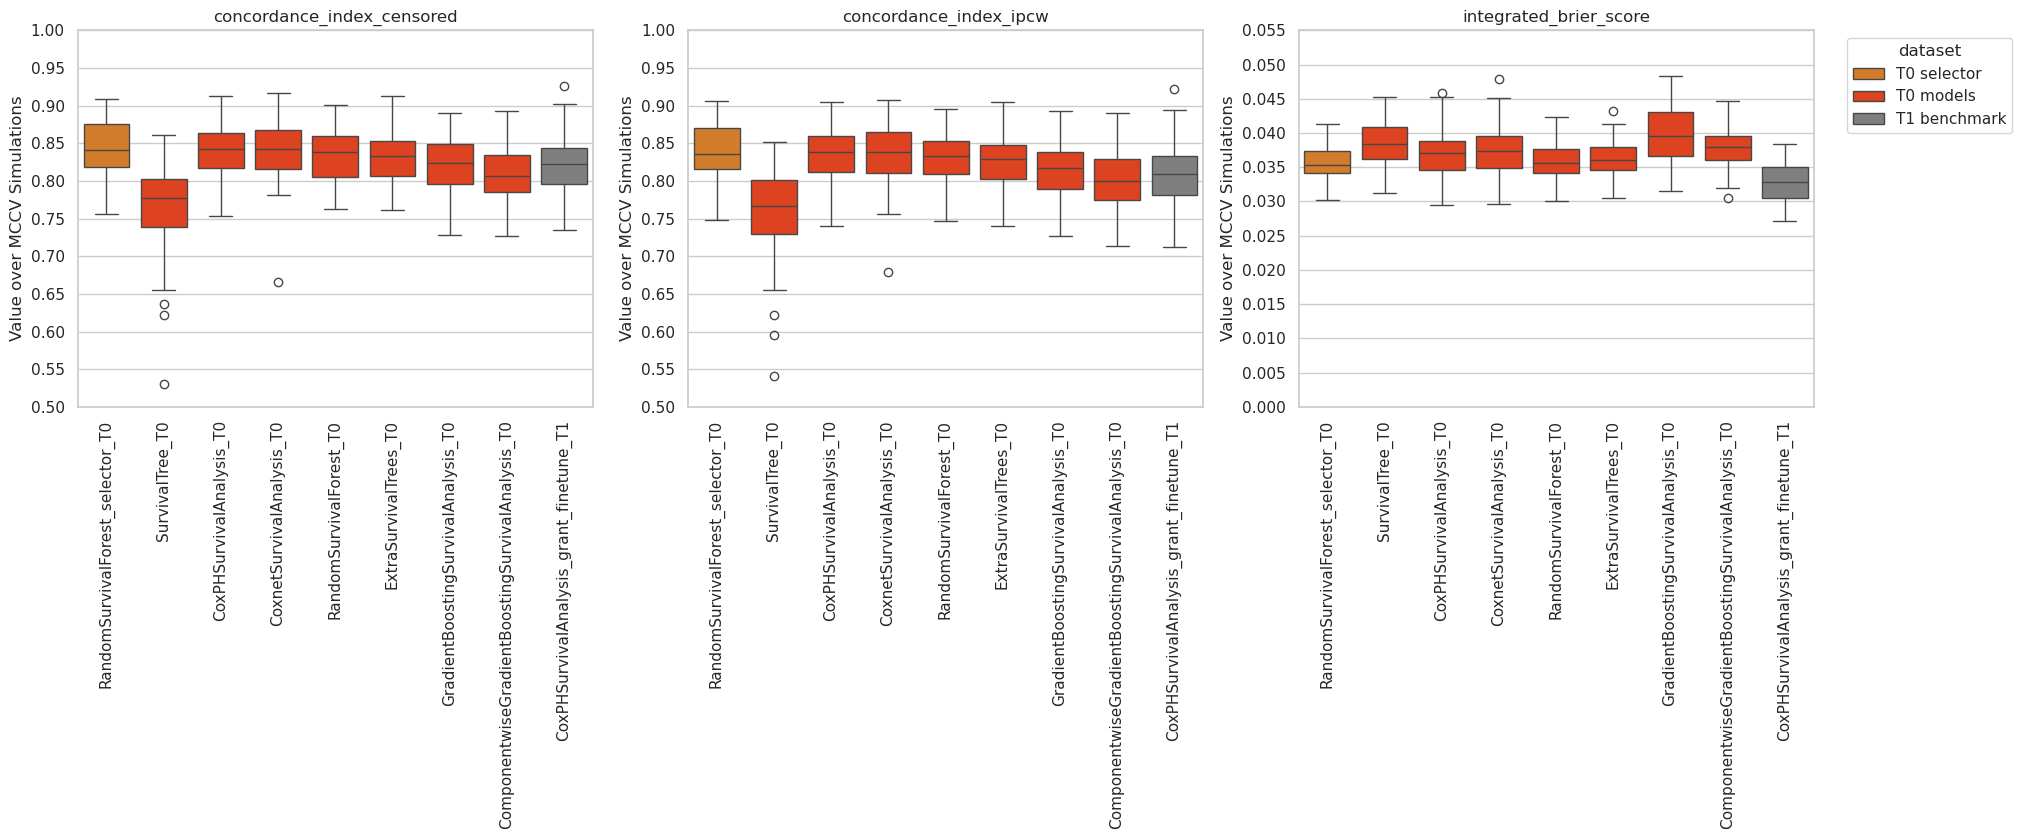

In [31]:
metrics = [
    'concordance_index_censored',
    'concordance_index_ipcw',
    'integrated_brier_score',
]
hue_column = "dataset"


# Determine the number of metrics to set up subplots
num_metrics = len(metrics)
cols = 3  # Number of columns in the subplot grid
rows = (num_metrics + cols - 1) // cols  # Calculate the number of rows needed
# Create the composite figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 9), squeeze=False)
axes_flat = axes.flatten()

dict_fig = {}
for idx, metric in tqdm(enumerate(metrics)):
    ax = axes_flat[idx]
    plot_metric_boxplot(
        df_metrics=df_metrics_t0,
        metric=metric,
        time_groups=time_groups_raw,
        color_groups=color_groups_raw,
        hue_column=None,
        ax=ax
    )
    if idx == len(metrics) - 1:
        # Add legend to the last ax
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title=hue_column, loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)
    else:
        # Remove legend
        ax.get_legend().remove()
    dict_fig[metric] = ax

# Hide any unused subplots
for idx in range(len(metrics), len(axes_flat)):
    fig.delaxes(axes_flat[idx])
# Adjust layout to accommodate the suptitle and the single legend
plt.tight_layout(rect=[0, 0, 0.85, 0.95])

# **Saving with Pillow to Control JPEG Quality**
# Create a buffer to save the figure as PNG
buf = BytesIO()
fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
buf.seek(0)
# Open the image with Pillow and save as JPEG with desired quality
img = Image.open(buf)
os.makedirs(DIR_FIGURES, exist_ok=True)
img.convert("RGB").save(os.path.join(DIR_FIGURES, "raw_t0_mccv_internal_val.jpg"), format='JPEG', quality=95)
plt.show()

# Number of features

## T1 + T0

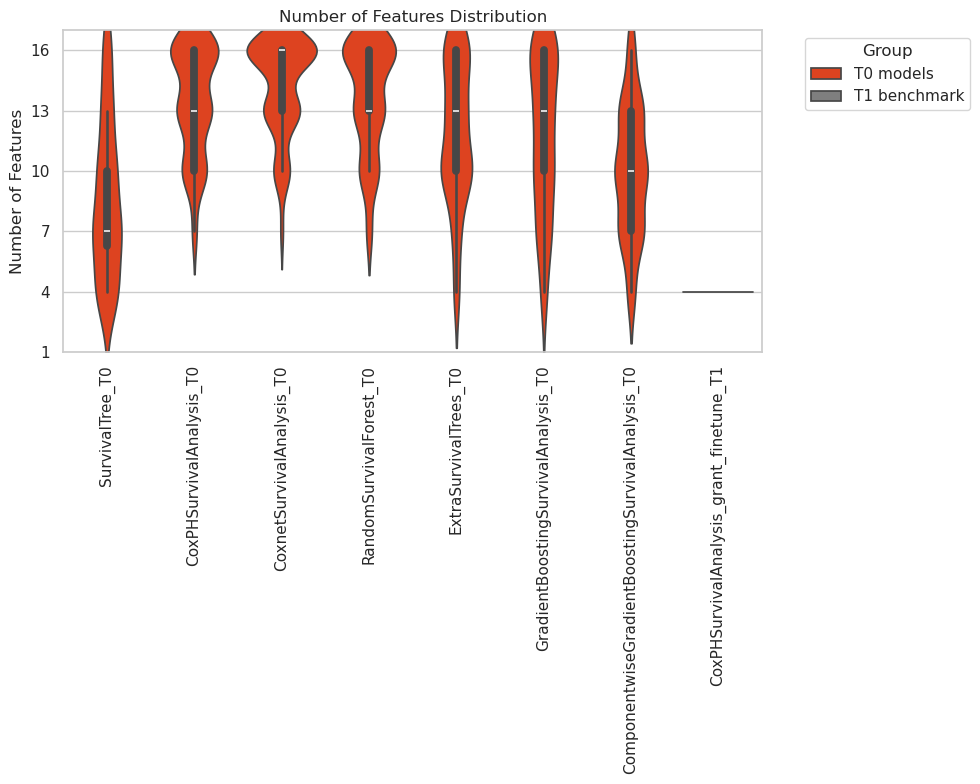

In [32]:
to_drop = time_groups_raw['T0 selector'] + time_groups_raw['T1 selector']
df_plot = df_metrics_t0[~df_metrics_t0['model'].isin(to_drop)]
plot_features_violin(df_plot, time_groups_raw, color_groups_raw, figsize=(10, 8))

## T1

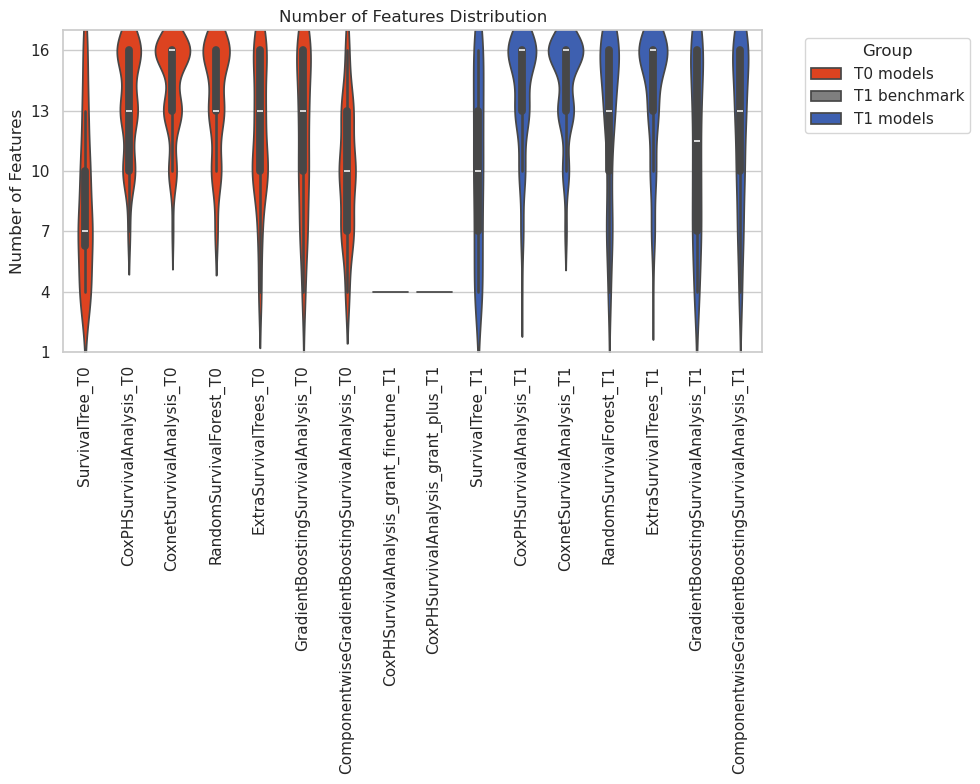

In [33]:
to_drop = time_groups_raw['T0 selector'] + time_groups_raw['T1 selector']
df_plot = df_metrics[~df_metrics['model'].isin(to_drop)]
plot_features_violin(df_plot, time_groups_raw, color_groups_raw, figsize=(10, 8))

# Aggregate by model

## Larcher vs raw dataset

In [34]:
assert len(df_metrics_vs['random_state'].unique()) == S
# Aggregate the metrics to get both mean and standard deviation
df_metrics_agg = (
    df_metrics_vs.groupby(["model", "dataset"])[
        [
            "best_performance_tuning",
            "concordance_index_censored",
            "concordance_index_ipcw",
            "mean_cumulative_dynamic_auc",
            "integrated_brier_score",
            "n_features_in"
        ]
    ]
    .agg(["mean"])
).droplevel(1, axis=1)
# Calculate the delta tuning validation using the mean values
df_metrics_agg[("delta_tuning_validation")] = (
    -df_metrics_agg[("best_performance_tuning")] - df_metrics_agg[("concordance_index_censored")]
)
# Drop the best_performance_tuning columns (both mean and std)
df_metrics_agg.drop(("best_performance_tuning"), axis=1, inplace=True)
# Round the values to 5 decimal places and sort by concordance_index_ipcw_mean
df_metrics_agg_rounded = df_metrics_agg.round(3).sort_values(("concordance_index_ipcw"), ascending=False)
df_metrics_agg_rounded

concordance_index_censored  \
model                                   dataset                                           
RandomSurvivalForest_selector_T1        Raw DBURI dataset                         0.888   
                                        Clinician’s dataset                       0.880   
CoxPHSurvivalAnalysis_grant_plus_T1     Raw DBURI dataset                         0.872   
                                        Clinician’s dataset                       0.870   
RandomSurvivalForest_selector_T0        Raw DBURI dataset                         0.844   
                                        Clinician’s dataset                       0.841   
CoxPHSurvivalAnalysis_grant_finetune_T1 Clinician’s dataset                       0.822   
                                        Raw DBURI dataset                         0.819   

                                                             concordance_index_ipcw  \
model                                   dataset                                       
RandomSurvivalForest_selector_T1        Raw DBURI dataset                     0.878   
                                        Clinician’s dataset                   0.871   
CoxPHSurvivalAnalysis_grant_plus_T1     Raw DBURI dataset                     0.862   
                                        Clinician’s dataset                   0.858   
RandomSurvivalForest_selector_T0        Raw DBURI dataset                     0.839   
                                        Clinician’s dataset                   0.834   
CoxPHSurvivalAnalysis_grant_finetune_T1 Clinician’s dataset                   0.809   
                                        Raw DBURI dataset                     0.807   

                                                             mean_cumulative_dynamic_auc  \
model                                   dataset                                            
RandomSurvivalForest_selector_T1        Raw DBURI dataset                          0.906   
                                        Clinician’s dataset                        0.898   
CoxPHSurvivalAnalysis_grant_plus_T1     Raw DBURI dataset                          0.893   
                                        Clinician’s dataset                        0.893   
RandomSurvivalForest_selector_T0        Raw DBURI dataset                          0.859   
                                        Clinician’s dataset                        0.859   
CoxPHSurvivalAnalysis_grant_finetune_T1 Clinician’s dataset                        0.850   
                                        Raw DBURI dataset                          0.844   

                                                             integrated_brier_score  \
model                                   dataset                                       
RandomSurvivalForest_selector_T1        Raw DBURI dataset                     0.032   
                                        Clinician’s dataset                   0.032   
CoxPHSurvivalAnalysis_grant_plus_T1     Raw DBURI dataset                     0.031   
                                        Clinician’s dataset                   0.031   
RandomSurvivalForest_selector_T0        Raw DBURI dataset                     0.036   
                                        Clinician’s dataset                   0.035   
CoxPHSurvivalAnalysis_grant_finetune_T1 Clinician’s dataset                   0.033   
                                        Raw DBURI dataset                     0.033   

                                                             n_features_in  \
model                                   dataset                              
RandomSurvivalForest_selector_T1        Raw DBURI dataset            206.0   
                                        Clinician’s dataset           69.0   
CoxPHSurvivalAnalysis_grant_plus_T1     Raw DBURI dataset              4.0   
                                        Clinician’s dataset            4.0   
RandomSurvivalFores

## All models on raw dataset

In [35]:
assert len(df_metrics['random_state'].unique()) == S
# Aggregate the metrics to get both mean and standard deviation
df_metrics_agg = (
    df_metrics.groupby(["model", "dataset"])[
        [
            "best_performance_tuning",
            "concordance_index_censored",
            "concordance_index_ipcw",
            "mean_cumulative_dynamic_auc",
            "integrated_brier_score",
            "n_features_in"
        ]
    ]
    .agg(["mean"])
).droplevel(1, axis=1)
# Calculate the delta tuning validation using the mean values
df_metrics_agg[("delta_tuning_validation")] = (
    -df_metrics_agg[("best_performance_tuning")] - df_metrics_agg[("concordance_index_censored")]
)
# Drop the best_performance_tuning columns (both mean and std)
df_metrics_agg.drop(("best_performance_tuning"), axis=1, inplace=True)
# Round the values to 5 decimal places and sort by concordance_index_ipcw_mean
df_metrics_agg_rounded = df_metrics_agg.round(5).sort_values(("concordance_index_ipcw"), ascending=False)
df_metrics_agg_rounded

,,concordance_index_censored,concordance_index_ipcw,mean_cumulative_dynamic_auc,integrated_brier_score,n_features_in,delta_tuning_validation
model,dataset,,,,,,
RandomSurvivalForest_selector_T1,Raw DBURI dataset,0.88753,0.87819,0.90599,0.03174,206.00,0.01110
CoxnetSurvivalAnalysis_T1,Raw DBURI dataset,0.88112,0.87269,0.89661,0.03527,14.26,0.07278
CoxPHSurvivalAnalysis_T1,Raw DBURI dataset,0.87990,0.87104,0.89564,0.03309,13.90,0.07168
ExtraSurvivalTrees_T1,Raw DBURI dataset,0.87277,0.86517,0.88669,0.03280,13.90,0.07658
CoxPHSurvivalAnalysis_grant_plus_T1,Raw DBURI dataset,0.87211,0.86214,0.89265,0.03079,4.00,NaN
ComponentwiseGradientBoostingSurvivalAnalysis_T1,Raw DBURI dataset,0.86157,0.85188,0.88023,0.03339,12.19,0.07918
GradientBoostingSurvivalAnalysis_T1,Raw DBURI dataset,0.85966,0.85035,0.87660,0.03645,11.14,0.08150
RandomSurvivalForest_T1,Raw DBURI dataset,0.85860,0.84990,0.87511,0.03280,12.76,0.08857
RandomSurvivalForest_selector_T0,Raw DBURI dataset,0.84420,0.83857,0.85897,0.03566,106.00,0.01799


`delta_tuning_validation` is an indicator for overfitting.

# Model of choice

In order to spot the best model, we apply the following :
- Remove the models with - on average over the simulations - more than 13 features as obtimal (hard to apply in a clinical environment)
- Normalization: Normalize each metric so that they are on the same scale, between 0 and 1. We'll use Min-Max normalization. This allows us to combine them meaningfully.
- Weight Assignment: Assign weights to each normalized metric based on their importance (our KPI is c-index). The weights are:
    - Concordance Index (IPCW) Mean: 0.5
    - Integrated Brier Score Mean: 0.25
    - Number of Features (n_features_in) Mean: 0.25

Note: For the metrics where "lower is better" (such as Integrated Brier Score Mean, Number of Features, and Delta Tuning Validation Mean), we will invert the normalized score by subtracting it from 1.
- Weighted Average Calculation: Compute the weighted average of these normalized metrics for each model.
- Ranking Models: Rank the models based on the calculated weighted average to identify the best model.

## T1

In [36]:
timepoint = "T1"
n_max = 13

# Filter feature selectors and GRANT models
df_metrics_best = df_metrics_agg_rounded.reset_index()
df_metrics_best = df_metrics_best[(df_metrics_best['model'].str.contains(timepoint)) & \
                                  (~df_metrics_best['model'].str.contains("_selector")) & \
                                  (~df_metrics_best['model'].str.contains("_grant"))]

# Exclude models with too many features
df_metrics_best = df_metrics_best[df_metrics_best['n_features_in'] < n_max]

# Normalization
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize each metric
df_metrics_best['concordance_index_ipcw_norm'] = min_max_normalize(df_metrics_best['concordance_index_ipcw'])
df_metrics_best['integrated_brier_score_norm'] = 1 - min_max_normalize(df_metrics_best['integrated_brier_score'])  # Lower is better
df_metrics_best['n_features_in_norm'] = 1 - min_max_normalize(df_metrics_best['n_features_in'])  # Lower is better

# Weights for each metric
weights = {
    'concordance_index_ipcw_norm': 0.5,
    'integrated_brier_score_norm': 0.2,
    'n_features_in_norm': 0.2,
}

# Calculate weighted average score
df_metrics_best['weighted_average_score'] = (
    df_metrics_best['concordance_index_ipcw_norm'] * weights['concordance_index_ipcw_norm'] +
    df_metrics_best['integrated_brier_score_norm'] * weights['integrated_brier_score_norm'] +
    df_metrics_best['n_features_in_norm'] * weights['n_features_in_norm']
)

# Drop intermediate columns
df_metrics_best = df_metrics_best.drop(["concordance_index_ipcw_norm", "integrated_brier_score_norm", "n_features_in_norm"], axis=1)

# Sort by weighted average score
model_t1 = df_metrics_best.sort_values(by='weighted_average_score', ascending=False).head(1)['model'].values[0]
print('Best model according to weighted average', model_t1)
df_metrics_best.sort_values(by='weighted_average_score', ascending=False).head(3)

Best model according to weighted average ComponentwiseGradientBoostingSurvivalAnalysis_T1


,model,dataset,concordance_index_censored,concordance_index_ipcw,mean_cumulative_dynamic_auc,integrated_brier_score,n_features_in,delta_tuning_validation,weighted_average_score
5,ComponentwiseGradientBoostingSurvivalAnalysis_T1,Raw DBURI dataset,0.86157,0.85188,0.88023,0.03339,12.19,0.07918,0.714585
7,RandomSurvivalForest_T1,Raw DBURI dataset,0.85860,0.84990,0.87511,0.03280,12.76,0.08857,0.675495
6,GradientBoostingSurvivalAnalysis_T1,Raw DBURI dataset,0.85966,0.85035,0.87660,0.03645,11.14,0.08150,0.614398


In [37]:
df_metrics[(df_metrics['model'] == model_t1)]['n_features_in'].value_counts().sort_index()

n_features_in
4      7
7     13
10    18
13    24
16    38
Name: count, dtype: int64

In [38]:
df_metrics[df_metrics['model'] == model_t1].groupby('n_features_in')['concordance_index_ipcw'].mean()

n_features_in
4     0.870933
7     0.856596
10    0.847580
13    0.858797
16    0.844416
Name: concordance_index_ipcw, dtype: float64

## T0

In [39]:
timepoint = "T0"
n_max = 13

# Filter feature selectors and GRANT models
df_metrics_best = df_metrics_agg_rounded.reset_index()
df_metrics_best = df_metrics_best[(df_metrics_best['model'].str.contains(timepoint)) & \
                                  (~df_metrics_best['model'].str.contains("_selector")) & \
                                  (~df_metrics_best['model'].str.contains("_grant"))]

# Exclude models with too many features
df_metrics_best = df_metrics_best[df_metrics_best['n_features_in'] < n_max]

# Normalization
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize each metric
df_metrics_best['concordance_index_ipcw_norm'] = min_max_normalize(df_metrics_best['concordance_index_ipcw'])
df_metrics_best['integrated_brier_score_norm'] = 1 - min_max_normalize(df_metrics_best['integrated_brier_score'])  # Lower is better
df_metrics_best['n_features_in_norm'] = 1 - min_max_normalize(df_metrics_best['n_features_in'])  # Lower is better
df_metrics_best['mean_cumulative_dynamic_auc_norm'] = min_max_normalize(df_metrics_best['mean_cumulative_dynamic_auc'])
df_metrics_best['delta_tuning_validation_norm'] = 1 - min_max_normalize(df_metrics_best['delta_tuning_validation'].fillna(df_metrics_best['delta_tuning_validation'].max()))  # Lower is better

# Weights for each metric
weights = {
    'concordance_index_ipcw_norm': 0.5,
    'integrated_brier_score_norm': 0.25,
    'n_features_in_norm': 0.25,
}

# Calculate weighted average score
df_metrics_best['weighted_average_score'] = (
    df_metrics_best['concordance_index_ipcw_norm'] * weights['concordance_index_ipcw_norm'] +
    df_metrics_best['integrated_brier_score_norm'] * weights['integrated_brier_score_norm'] +
    df_metrics_best['n_features_in_norm'] * weights['n_features_in_norm']
)

# Drop intermediate columns
df_metrics_best = df_metrics_best.drop(["concordance_index_ipcw_norm", "integrated_brier_score_norm", "n_features_in_norm",
                                        "mean_cumulative_dynamic_auc_norm", "delta_tuning_validation_norm"], axis=1)

# Sort by weighted average score
model_t0 = df_metrics_best.sort_values(by='weighted_average_score', ascending=False).head(1)['model'].values[0]
print('Best model according to weighted average', model_t0)
df_metrics_best.sort_values(by='weighted_average_score', ascending=False).head(3)

Best model according to weighted average ExtraSurvivalTrees_T0


,model,dataset,concordance_index_censored,concordance_index_ipcw,mean_cumulative_dynamic_auc,integrated_brier_score,n_features_in,delta_tuning_validation,weighted_average_score
12,ExtraSurvivalTrees_T0,Raw DBURI dataset,0.82974,0.82456,0.83914,0.03625,11.77,0.09114,0.750000
16,ComponentwiseGradientBoostingSurvivalAnalysis_T0,Raw DBURI dataset,0.80932,0.80034,0.82652,0.03771,9.97,0.08935,0.594674
13,GradientBoostingSurvivalAnalysis_T0,Raw DBURI dataset,0.82211,0.81431,0.83911,0.03979,11.68,0.09338,0.425583


In [40]:
df_metrics[(df_metrics['model'] == model_t0)]['n_features_in'].value_counts().sort_index()

n_features_in
4      6
7      9
10    34
13    22
16    29
Name: count, dtype: int64

In [41]:
df_metrics[df_metrics['model'] == model_t0].groupby('n_features_in')['concordance_index_ipcw'].mean()

n_features_in
4     0.836059
7     0.828992
10    0.822506
13    0.832084
16    0.817499
Name: concordance_index_ipcw, dtype: float64